In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
#import bambi as bmb
import xarray as xr
import random
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('paper')
sns.set_style('ticks')
plt.rc("axes.spines", top=False, right=False)
with matplotlib.style.context('arviz-doc'):
    az_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
sns.set_palette(az_colors)

def origo(ax=None):
    if ax is None:
        ax = plt.gca()
    x, y = ax.get_xlim(), ax.get_ylim()
    minx, maxx = min(x), max(x)
    miny, maxy = min(y), max(y)
    plt.ylim(min(0, miny), max(0, maxy))
    plt.xlim(min(0, minx), max(0, maxx))

class columns:
    def __rlshift__(self, df):
        "Left align columns of data frame: df << left()"
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector = 'th', props=[('text-align', 'left')])])
        display(left_aligned_df)
        

In [2]:
# scale = 0.35
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context().items() if v is not None])
# d['figure.figsize'] = [1.8, 1.3]
# matplotlib.rcParams.update(d)
# make context for with statement:
# #matplotlib.style.context(d)

In [3]:
# plt.plot(np.random.random(10), np.random.random(10)-10)
# origo()

In [4]:
#Disable annoying "UserWarning: The figure layout has changed to tight" message
import warnings
warnings.filterwarnings('ignore', category=UserWarning
                        # , module='seaborn'
                       )
warnings.filterwarnings('ignore', category=FutureWarning,
                        # module='matplotlib'
                       )

# Read in data

Filter based on callability and remove X chromosome and adjust for missing coverage by extrapolating

In [5]:
data = pd.read_csv('Reduced_Ne_Pi_recomb.csv')
#data.full_species.unique()

In [6]:
data = data[data['freq_mean']>0.7]
data = data[data['chr']!='chrX']
data['corrected_pi'] = data['PI']*data['freq_mean']

In [7]:
selected_groups = ['Gorilla_gorilla', 'Chiropotes_albinasus', 'Saimiri_ustus']
#selected_groups = data.full_species.unique()[:50]

In [8]:
# # subset data for testing
# data = data.loc[(data['chr'] == 'chr1') & (data.full_species.isin(selected_groups))]
# data = data.loc[(data['chr'] == 'chr1')]
# data = data.loc[(data.full_species.isin(selected_groups))]
data.reset_index(drop=True, inplace=True)
data.head()

Unnamed: 0           genus       species                 full_species  \
0           2  Allenopithecus  nigroviridis  Allenopithecus_nigroviridis   
1           3  Allenopithecus  nigroviridis  Allenopithecus_nigroviridis   
2           4  Allenopithecus  nigroviridis  Allenopithecus_nigroviridis   
3           5  Allenopithecus  nigroviridis  Allenopithecus_nigroviridis   
4           6  Allenopithecus  nigroviridis  Allenopithecus_nigroviridis   

           MEAN        MEDIAN       NE_MEAN     NE_MEDIAN  freq_mean  \
0  8.357479e-09  8.297569e-09  52454.392022  48795.239046   0.809708   
1  8.357479e-09  8.297569e-09  52454.392022  48795.239046   0.716477   
2  8.357479e-09  8.297569e-09  52454.392022  48795.239046   0.784308   
3  8.357479e-09  8.297569e-09  52454.392022  48795.239046   0.747552   
4  8.357479e-09  8.297569e-09  52454.392022  48795.239046   0.783023   

   cm_per_mb   chr        PI  corrected_pi  
0   0.032423  chr1  0.001810      0.001466  
1   1.734505  chr1  0.002047      0.001466  
2   1.056430  chr1  0.002565      0.002012  
3   0.420616  chr1  0.001845      0.001379  
4   1.470184  chr1  0.001713      0.001342

In [9]:
data.full_species.unique()

array(['Allenopithecus_nigroviridis', 'Allochrocebus_lhoesti',
       'Allochrocebus_preussi', 'Allochrocebus_solatus',
       'Alouatta_belzebul', 'Alouatta_caraya', 'Alouatta_discolor',
       'Alouatta_juara', 'Alouatta_macconnelli', 'Alouatta_nigerrima',
       'Alouatta_palliata', 'Alouatta_puruensis', 'Alouatta_seniculus',
       'Aotus_azarae', 'Aotus_griseimembra', 'Aotus_trivirgatus',
       'Aotus_vociferans', 'Arctocebus_calabarensis', 'Ateles_belzebuth',
       'Ateles_chamek', 'Ateles_geoffroyi', 'Ateles_marginatus',
       'Ateles_paniscus', 'Cacajao_ayresi', 'Cacajao_calvus',
       'Cacajao_hosomi', 'Cacajao_melanocephalus', 'Callimico_goeldii',
       'Callithrix_geoffroyi', 'Callithrix_jacchus', 'Callithrix_kuhlii',
       'Cebuella_niveiventris', 'Cebuella_pygmaea', 'Cebus_albifrons',
       'Cebus_olivaceus', 'Cebus_unicolor', 'Cercocebus_chrysogaster',
       'Cercocebus_lunulatus', 'Cercocebus_torquatus',
       'Cercopithecus_ascanius', 'Cercopithecus_cephus',
  

In [10]:
np.log10(data['NE_MEDIAN'].mean()), np.log10(data['NE_MEDIAN']).mean()

(4.845759193883429, 4.749171266594735)

# Transform data

In [11]:
species_encoder = LabelEncoder()

gr = data.groupby('full_species')

df = pd.DataFrame(dict(
    
    # log scale and z transform Ne globally
    Ne = data.NE_MEDIAN.transform(np.log1p).transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # log scale and z transform recombination rate by species
    rec_rate = gr.cm_per_mb.transform(np.log1p).transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # z transform pi by species
    pi = gr.corrected_pi.transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # species name for each observation
    full_species = data.full_species,

    # species to integer transform
    species = species_encoder.fit_transform(data.full_species)
    
))

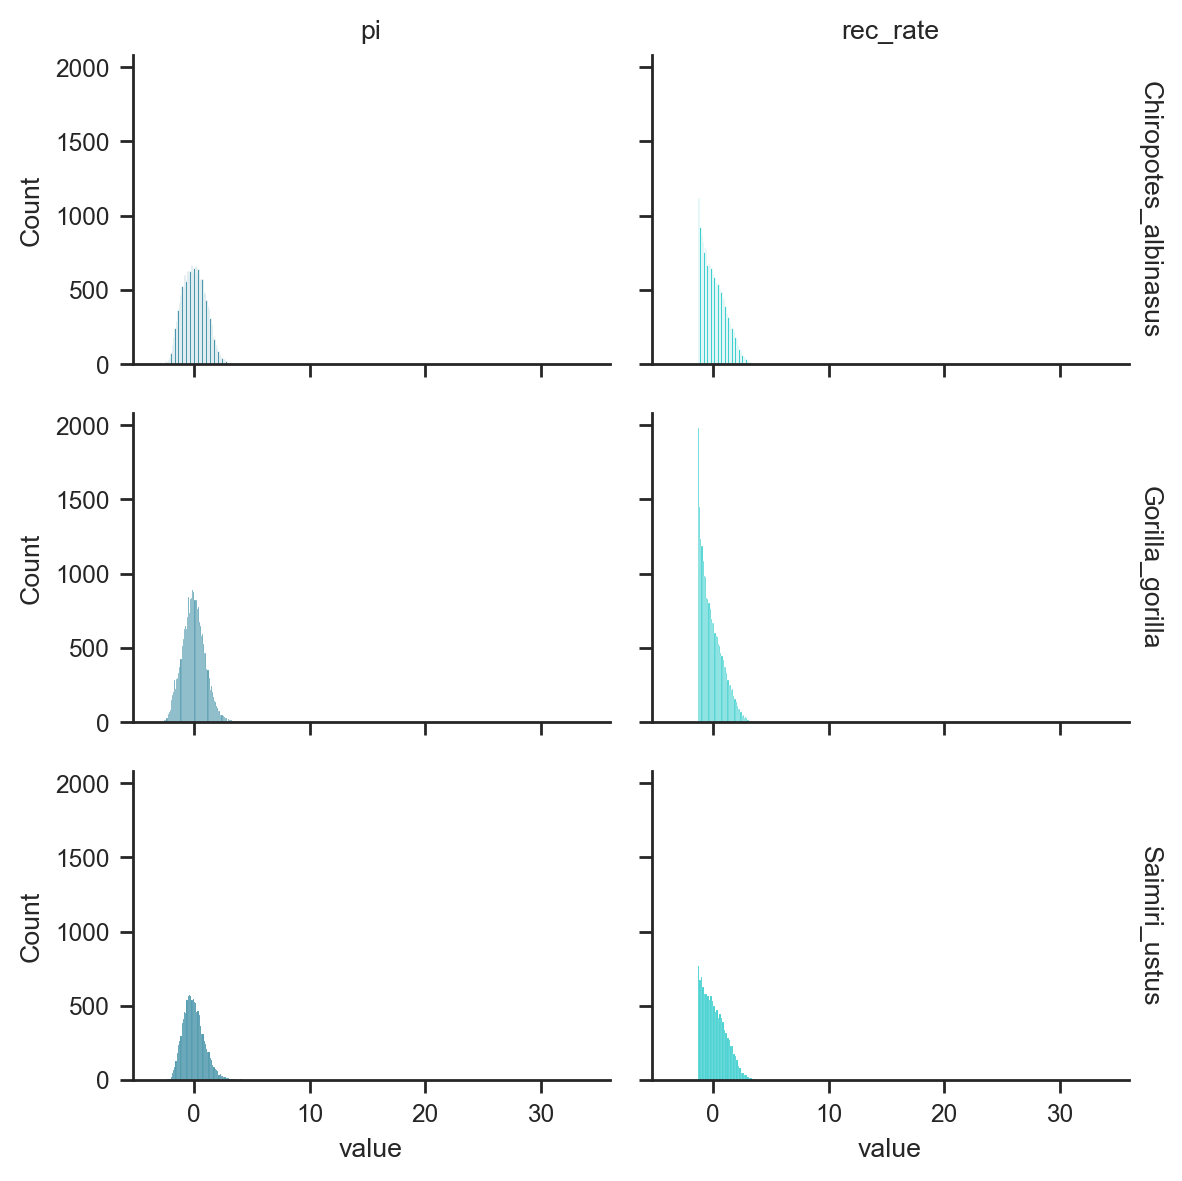

In [12]:
plot_df = df.loc[df.full_species.isin(selected_groups)].melt(id_vars='full_species', value_vars=['pi', 'rec_rate'])
g = sns.FacetGrid(plot_df, col="variable", row="full_species", hue="variable", margin_titles=True, height=2, aspect=1.5)
g.map_dataframe(sns.histplot, x="value")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
for ax in g.axes.flat:
    title = ax.get_title()
    ax.set_title(title, rotation=0)
plt.tight_layout()

In [13]:
# population_idx = 
# background_pi = 
# admixture_prop = 

# population_label = 
# dist_from_hybzone = 

# Observations

In [14]:
window_y_values = df.pi.values
window_x_values = df.rec_rate.values
global_group_names = pd.unique(species_encoder.inverse_transform(df.species))
global_group_indices = df.species
global_group_values = df[['full_species', 'Ne']].drop_duplicates().Ne.values

assert len(global_group_names) == len(global_group_values)
assert len(window_y_values) == len(window_x_values)
assert len(window_x_values) == len(global_group_indices)

# Hierarchical model

In [15]:
model_hierarchical = pm.Model(coords = {"global_group": global_group_names,
                           "obs_id": np.arange(len(window_x_values))})
non_centered = True

with model_hierarchical:
    # data
    window_dependent = pm.ConstantData('window_dependent', window_x_values, dims='obs_id')
    window_independent = pm.ConstantData('window_independent', window_y_values, dims='obs_id')
    global_group_member = pm.ConstantData('global_group_member', global_group_indices, dims='obs_id')
    global_dependent =  pm.ConstantData('global_dependent', global_group_values, dims='global_group')

    # hyperprior on window_independent ~ window_dependent intercept prior
    hyp_inter_inter = pm.Normal("hyp_inter_inter", mu=0, sigma=1)
    hyp_inter_slope = pm.Normal("hyp_inter_slope", mu=0, sigma=1)
    
    # hyperprior on window_independent ~ window_dependent slope prior
    hyp_slope_inter = pm.Normal("hyp_slope_inter", mu=0, sigma=1)
    hyp_slope_slope = pm.Normal("hyp_slope_slope", mu=0, sigma=1)

    # prior on residual variation on global_group intercepts
    group_inter_residual = pm.Normal("group_inter_residual", 0, sigma=1, dims="global_group")
    
    # prior on residual variation on global_group slopes
    group_slope_residual = pm.Normal("group_slope_residual", 0, sigma=1, dims="global_group")

    # prior on window_independent ~ window_dependent intercept for each global_group
    mu_inter = hyp_inter_inter + hyp_inter_slope * global_dependent
    sigma_inter = pm.Exponential("sigma_inter", 1)
    group_inter = pm.Deterministic("group_inter", mu_inter + group_inter_residual * sigma_inter, dims="global_group")

    # prior on window_independent ~ window_dependent slope for each global_group
    mu_slope = hyp_slope_inter + hyp_slope_slope * global_dependent
    sigma_slope = pm.Exponential("sigma_slope", 1)
    group_slope = pm.Deterministic("group_slope", mu_slope + group_slope_residual * sigma_slope, dims="global_group")
        
    # prior window_independent ~ window_dependent slope for each global_group
    mu_window_independent = group_inter[global_group_member] + group_slope[global_group_member] * window_dependent
    sigma_window_independent = pm.Exponential("sigma_window_independent", 0.01)

    # prior
    WindowIndependent = pm.Normal("Independent", mu=mu_window_independent, sigma=sigma_window_independent, observed=window_independent, dims="obs_id")

In [16]:
%%capture
fig, ax = plt.subplots()
g = pm.model_to_graphviz(model_hierarchical)
g.graph_attr.update(size="10,10")

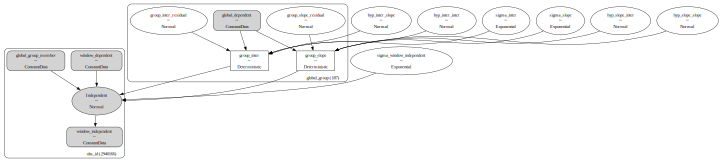

In [17]:
g

## Prior predictive checks

In [18]:
with model_hierarchical:
    idata_hierarchical = pm.sample_prior_predictive()

Sampling: [Independent, group_inter_residual, group_slope_residual, hyp_inter_inter, hyp_inter_slope, hyp_slope_inter, hyp_slope_slope, sigma_inter, sigma_slope, sigma_window_independent]


In [19]:
prior = idata_hierarchical.prior.squeeze(drop=True)

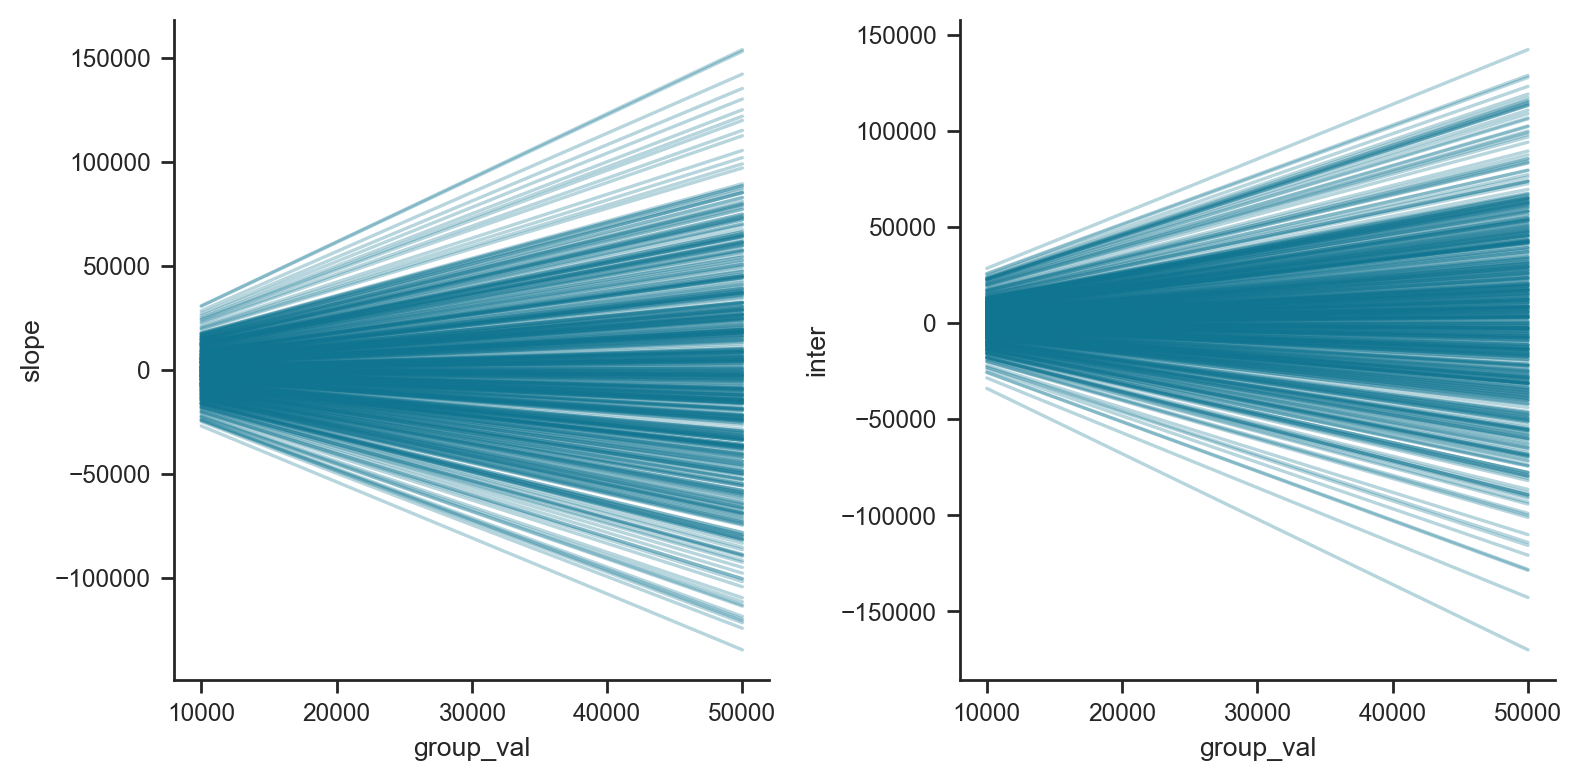

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

group_val = xr.DataArray(np.linspace(10000, 50000, 200), dims=["plot_dim"])
prior = idata_hierarchical.prior

slope = prior["hyp_slope_inter"] + prior["hyp_slope_slope"] * group_val
ax1.plot(group_val, slope.stack(sample=("chain", "draw")), c="C0", alpha=0.3)
ax1.set_xlabel("group_val")
ax1.set_ylabel("slope") 
inter = prior["hyp_inter_inter"] + prior["hyp_slope_inter"] * group_val
ax2.plot(group_val, inter.stack(sample=("chain", "draw")), c="C0", alpha=0.3)
ax2.set_xlabel("group_val")
ax2.set_ylabel("inter")
plt.tight_layout()

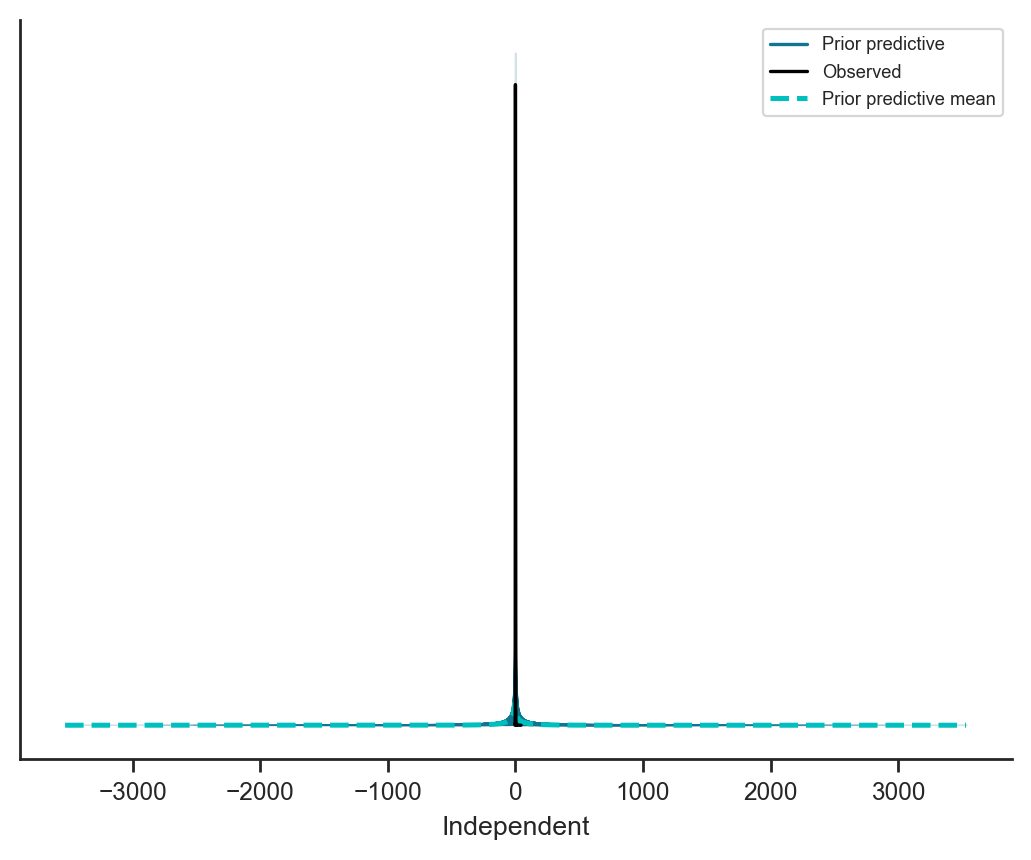

In [21]:
az.plot_ppc(idata_hierarchical, group='prior') ;

## Model trace

In [22]:
use_cached = True

trace_file = 'model_hierarchical.nc'
if use_cached and os.path.exists(trace_file):
    with model_hierarchical:
         trace = az.from_netcdf(trace_file)
else:
    with model_hierarchical:
        trace = pm.sample(#1000, 
                          target_accept=0.95, 
                          return_inferencedata=True,
                          progressbar=True, 
            # cores=4, chains=4
        )
        trace.to_netcdf(trace_file)

idata_hierarchical.extend(trace)


## Trace diagnostics

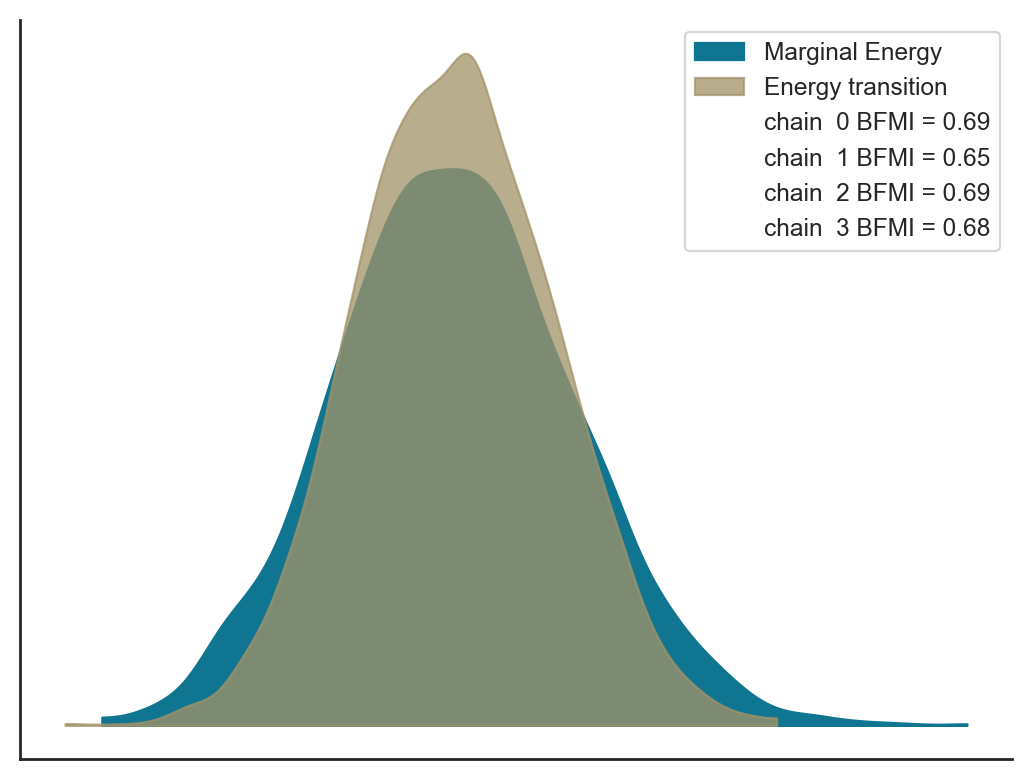

In [23]:
az.plot_energy(idata_hierarchical);

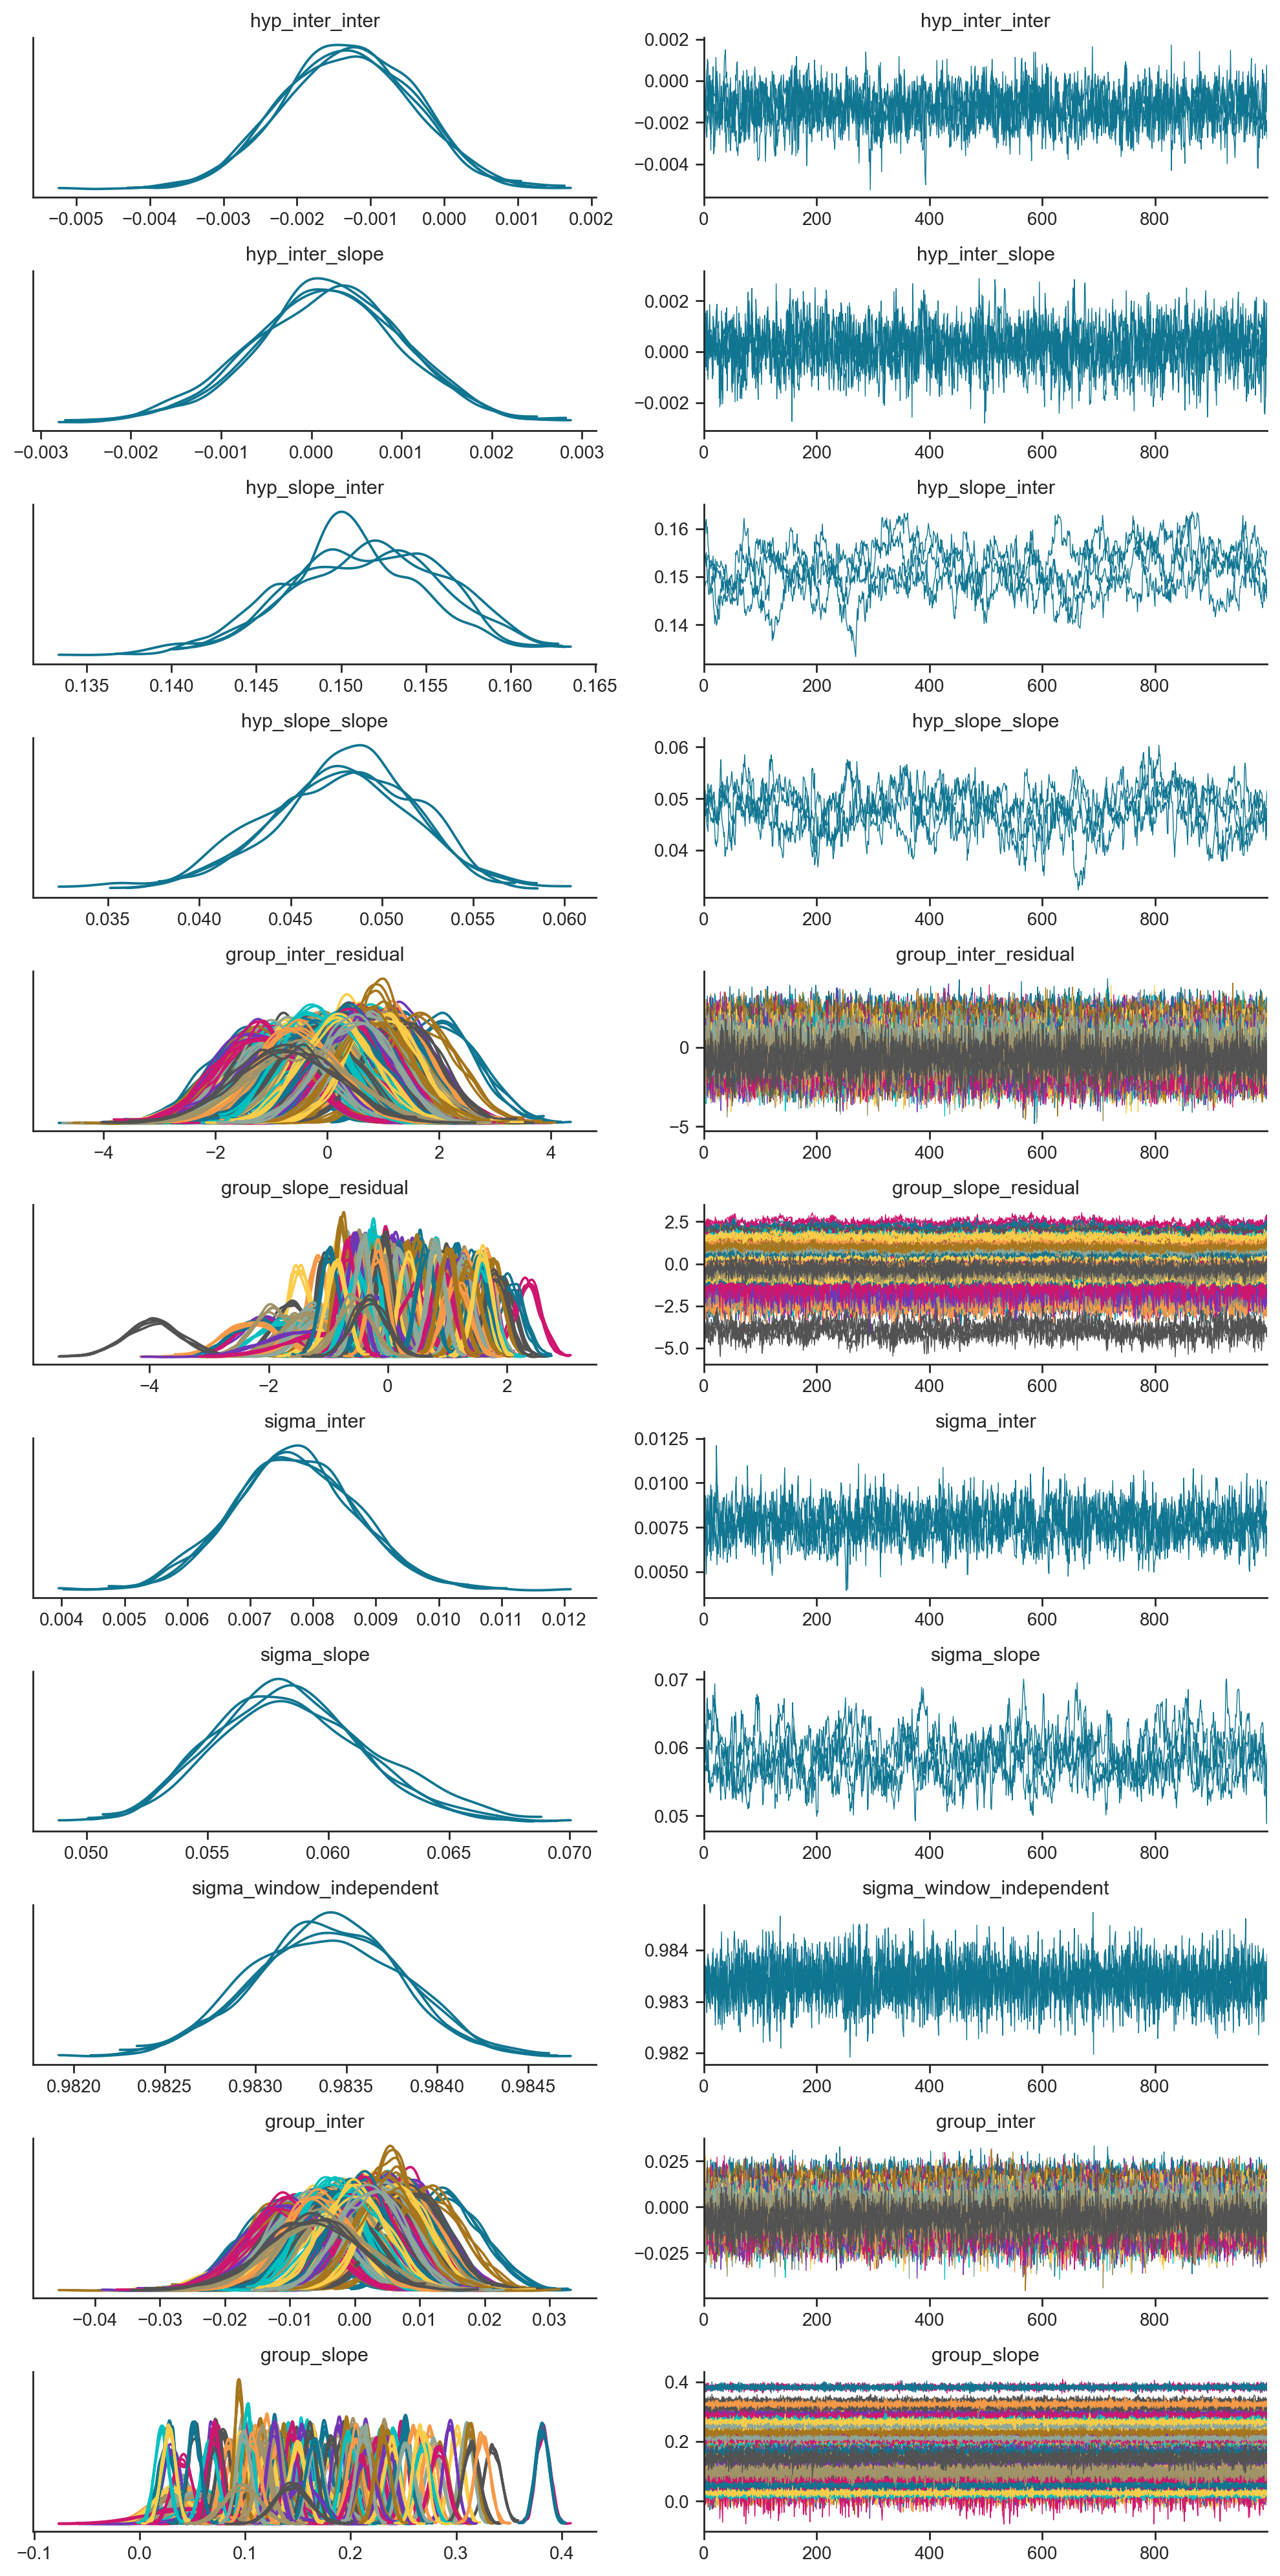

In [24]:
az.plot_trace(idata_hierarchical,
    # var_names=[],
    compact=True,
    figsize=(10, 20),
    chain_prop=dict(linestyle='-'),
    trace_kwargs=dict(linestyle='-', linewidth=0.5, alpha=1),
             )
plt.tight_layout()

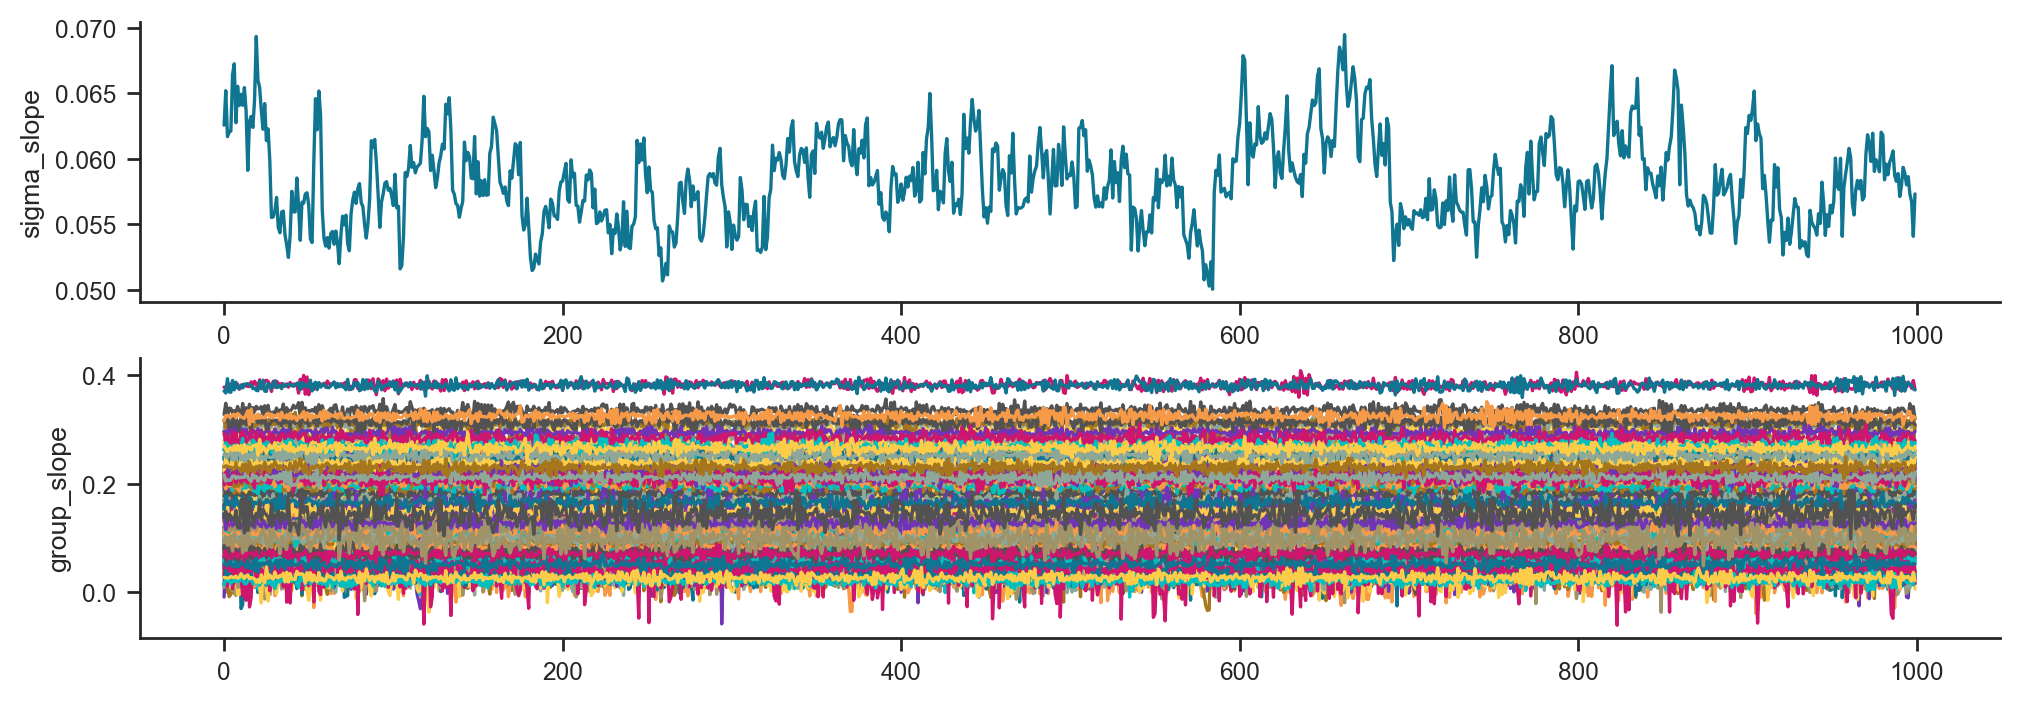

In [25]:
fig, axs = plt.subplots(nrows=2, figsize=(12,  4))
axs[0].plot(idata_hierarchical.posterior.sel(chain=0)["sigma_slope"])
axs[0].set(ylabel="sigma_slope")
axs[1].plot(idata_hierarchical.posterior.sel(chain=0)["group_slope"])
axs[1].set(ylabel="group_slope");

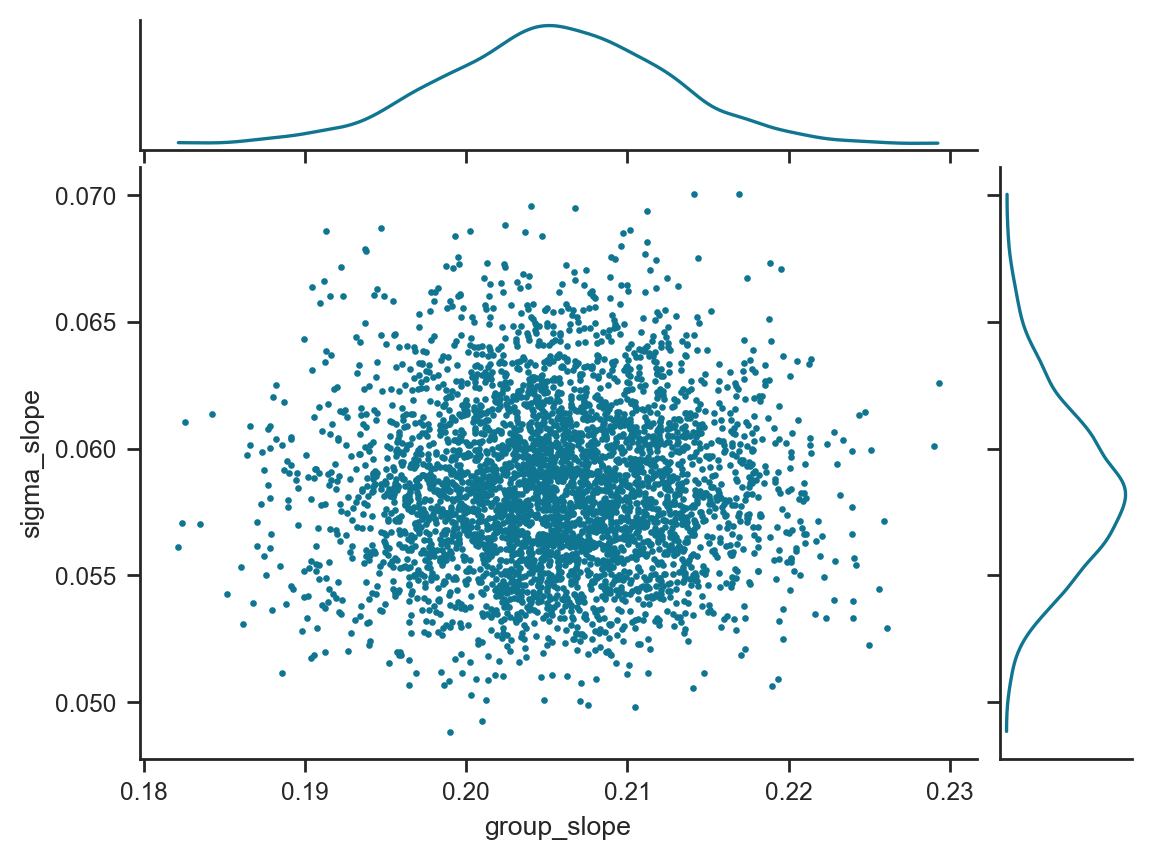

In [26]:
ax = az.plot_pair(
    idata_hierarchical,
    var_names=["group_slope", "sigma_slope"],
    coords=dict(global_group=selected_groups[0]),
    marginals=True,
    #marginal_kwargs={"kind": "hist"},
)
#ax[1, 0].set_title(selected_groups[1])

## Posterior predictive checks

In [27]:
# with model_hierarchical:
#     idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

# thin a sampled inferencedata by keeping 1 out of every 5 draws before passing it to sample_posterior_predictive
thinned_idata = idata_hierarchical.sel(draw=slice(None, None, 5))
with model_hierarchical:
    idata_hierarchical.extend(pm.sample_posterior_predictive(thinned_idata))

# # generate 5 posterior predictive samples per posterior sample
# expanded_data = idata_hierarchical.posterior.expand_dims(pred_id=5)
# with model_hierarchical:
#     idata_hierarchical.extend(pm.sample_posterior_predictive(expanded_data))

Sampling: [Independent]


In [28]:
#idata_hierarchical.to_netcdf('idata_hierarchical.nc')

In [29]:
#idata_hierarchical = az.from_netcdf('idata_hierarchical.nc')

In [30]:
az.summary(idata_hierarchical, round_to=2)

mean    sd  hdi_3%  \
hyp_inter_inter                                   -0.00  0.00   -0.00   
hyp_inter_slope                                    0.00  0.00   -0.00   
hyp_slope_inter                                    0.15  0.00    0.14   
hyp_slope_slope                                    0.05  0.00    0.04   
group_inter_residual[Allenopithecus_nigroviridis]  0.61  0.65   -0.60   
...                                                 ...   ...     ...   
group_slope[Trachypithecus_melamera]               0.11  0.01    0.09   
group_slope[Trachypithecus_phayrei]                0.03  0.01    0.02   
group_slope[Trachypithecus_pileatus]               0.10  0.01    0.09   
group_slope[Varecia_rubra]                         0.10  0.02    0.07   
group_slope[Varecia_variegata]                     0.14  0.02    0.11   

                                                   hdi_97%  mcse_mean  \
hyp_inter_inter                                       0.00       0.00   
hyp_inter_slope                                       0.00       0.00   
hyp_slope_inter                                       0.16       0.00   
hyp_slope_slope                                       0.05       0.00   
group_inter_residual[Allenopithecus_nigroviridis]     1.86       0.01   
...                                                    ...        ...   
group_slope[Trachypithecus_melamera]                  0.12       0.00   
group_slope[Trachypithecus_phayrei]                   0.04       0.00   
group_slope[Trachypithecus_pileatus]                  0.11       0.00   
group_slope[Varecia_rubra]                            0.13       0.00   
group_slope[Varecia_variegata]                        0.17       0.00   

                                                   mcse_sd  ess_bulk  \
hyp_inter_inter                                       0.00   1439.51   
hyp_inter_slope                                       0.00   1626.10   
hyp_slope_inter                                       0.00     93.23   
hyp_slope_slope                                       0.00    134.39   
group_inter_residual[Allenopithecus_nigroviridis]     0.01   4204.45   
...                                                    ...       ...   
group_slope[Trachypithecus_melamera]                  0.00   5978.97   
group_slope[Trachypithecus_phayrei]                   0.00   8770.04   
group_slope[Trachypithecus_pileatus]                  0.00   6483.78   
group_slope[Varecia_rubra]                            0.00   4425.54   
group_slope[Varecia_variegata]                        0.00   4508.52   

                                                   ess_tail  r_hat  
hyp_inter_inter                                     1959.60   1.00  
hyp_inter_slope                                     2351.06   1.00  
hyp_slope_inter                                      246.71   1.04  
hyp_slope_slope                                      485.30   1.03  
group_inter_residual[Allenopithecus_nigroviridis]   2443.92   1.00  
...                                                     ...    ...  
group_slope[Trachypithecus_melamera]                3266.41   1.00  
group_slope[Trachypithecus_phayrei]                 3002.35   1.00  
group_slope[Trachypithecus_pileatus]                3159.89   1.00  
group_slope[Varecia_rubra]                          3126.50   1.00  
group_slope[Varecia_variegata]                      2895.64   1.00  

[755 rows x 9 columns]

In [31]:
post_mean = idata_hierarchical.posterior.mean(dim=("chain", "draw"))

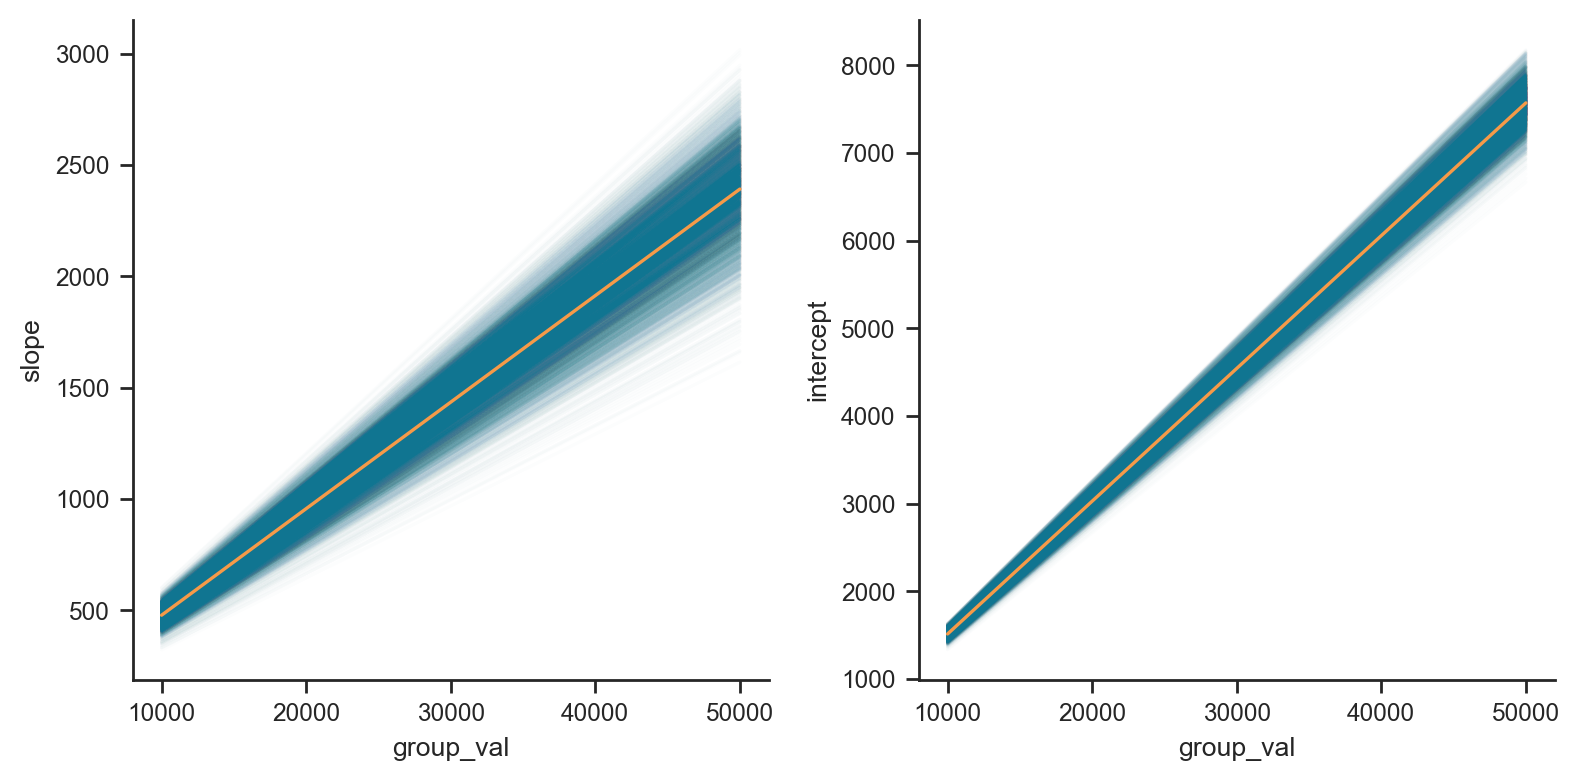

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

group_val = xr.DataArray(np.linspace(10000, 50000, 200), dims=["plot_dim"])
posterior = idata_hierarchical.posterior

slope = posterior["hyp_slope_inter"] + posterior["hyp_slope_slope"] * group_val
ax1.plot(group_val, slope.stack(sample=("chain", "draw")), c="C0", alpha=0.01)
ax1.plot(group_val, post_mean["hyp_slope_inter"] + post_mean["hyp_slope_slope"] * group_val, c="C2")
ax1.set_xlabel("group_val")
ax1.set_ylabel("slope") 
inter = posterior["hyp_inter_inter"] + posterior["hyp_slope_inter"] * group_val
ax2.plot(group_val, inter.stack(sample=("chain", "draw")), c="C0", alpha=0.01)
ax2.plot(group_val, post_mean["hyp_inter_inter"] + post_mean["hyp_slope_inter"] * group_val, c="C2")
ax2.set_xlabel("group_val")
ax2.set_ylabel("intercept")
plt.tight_layout()

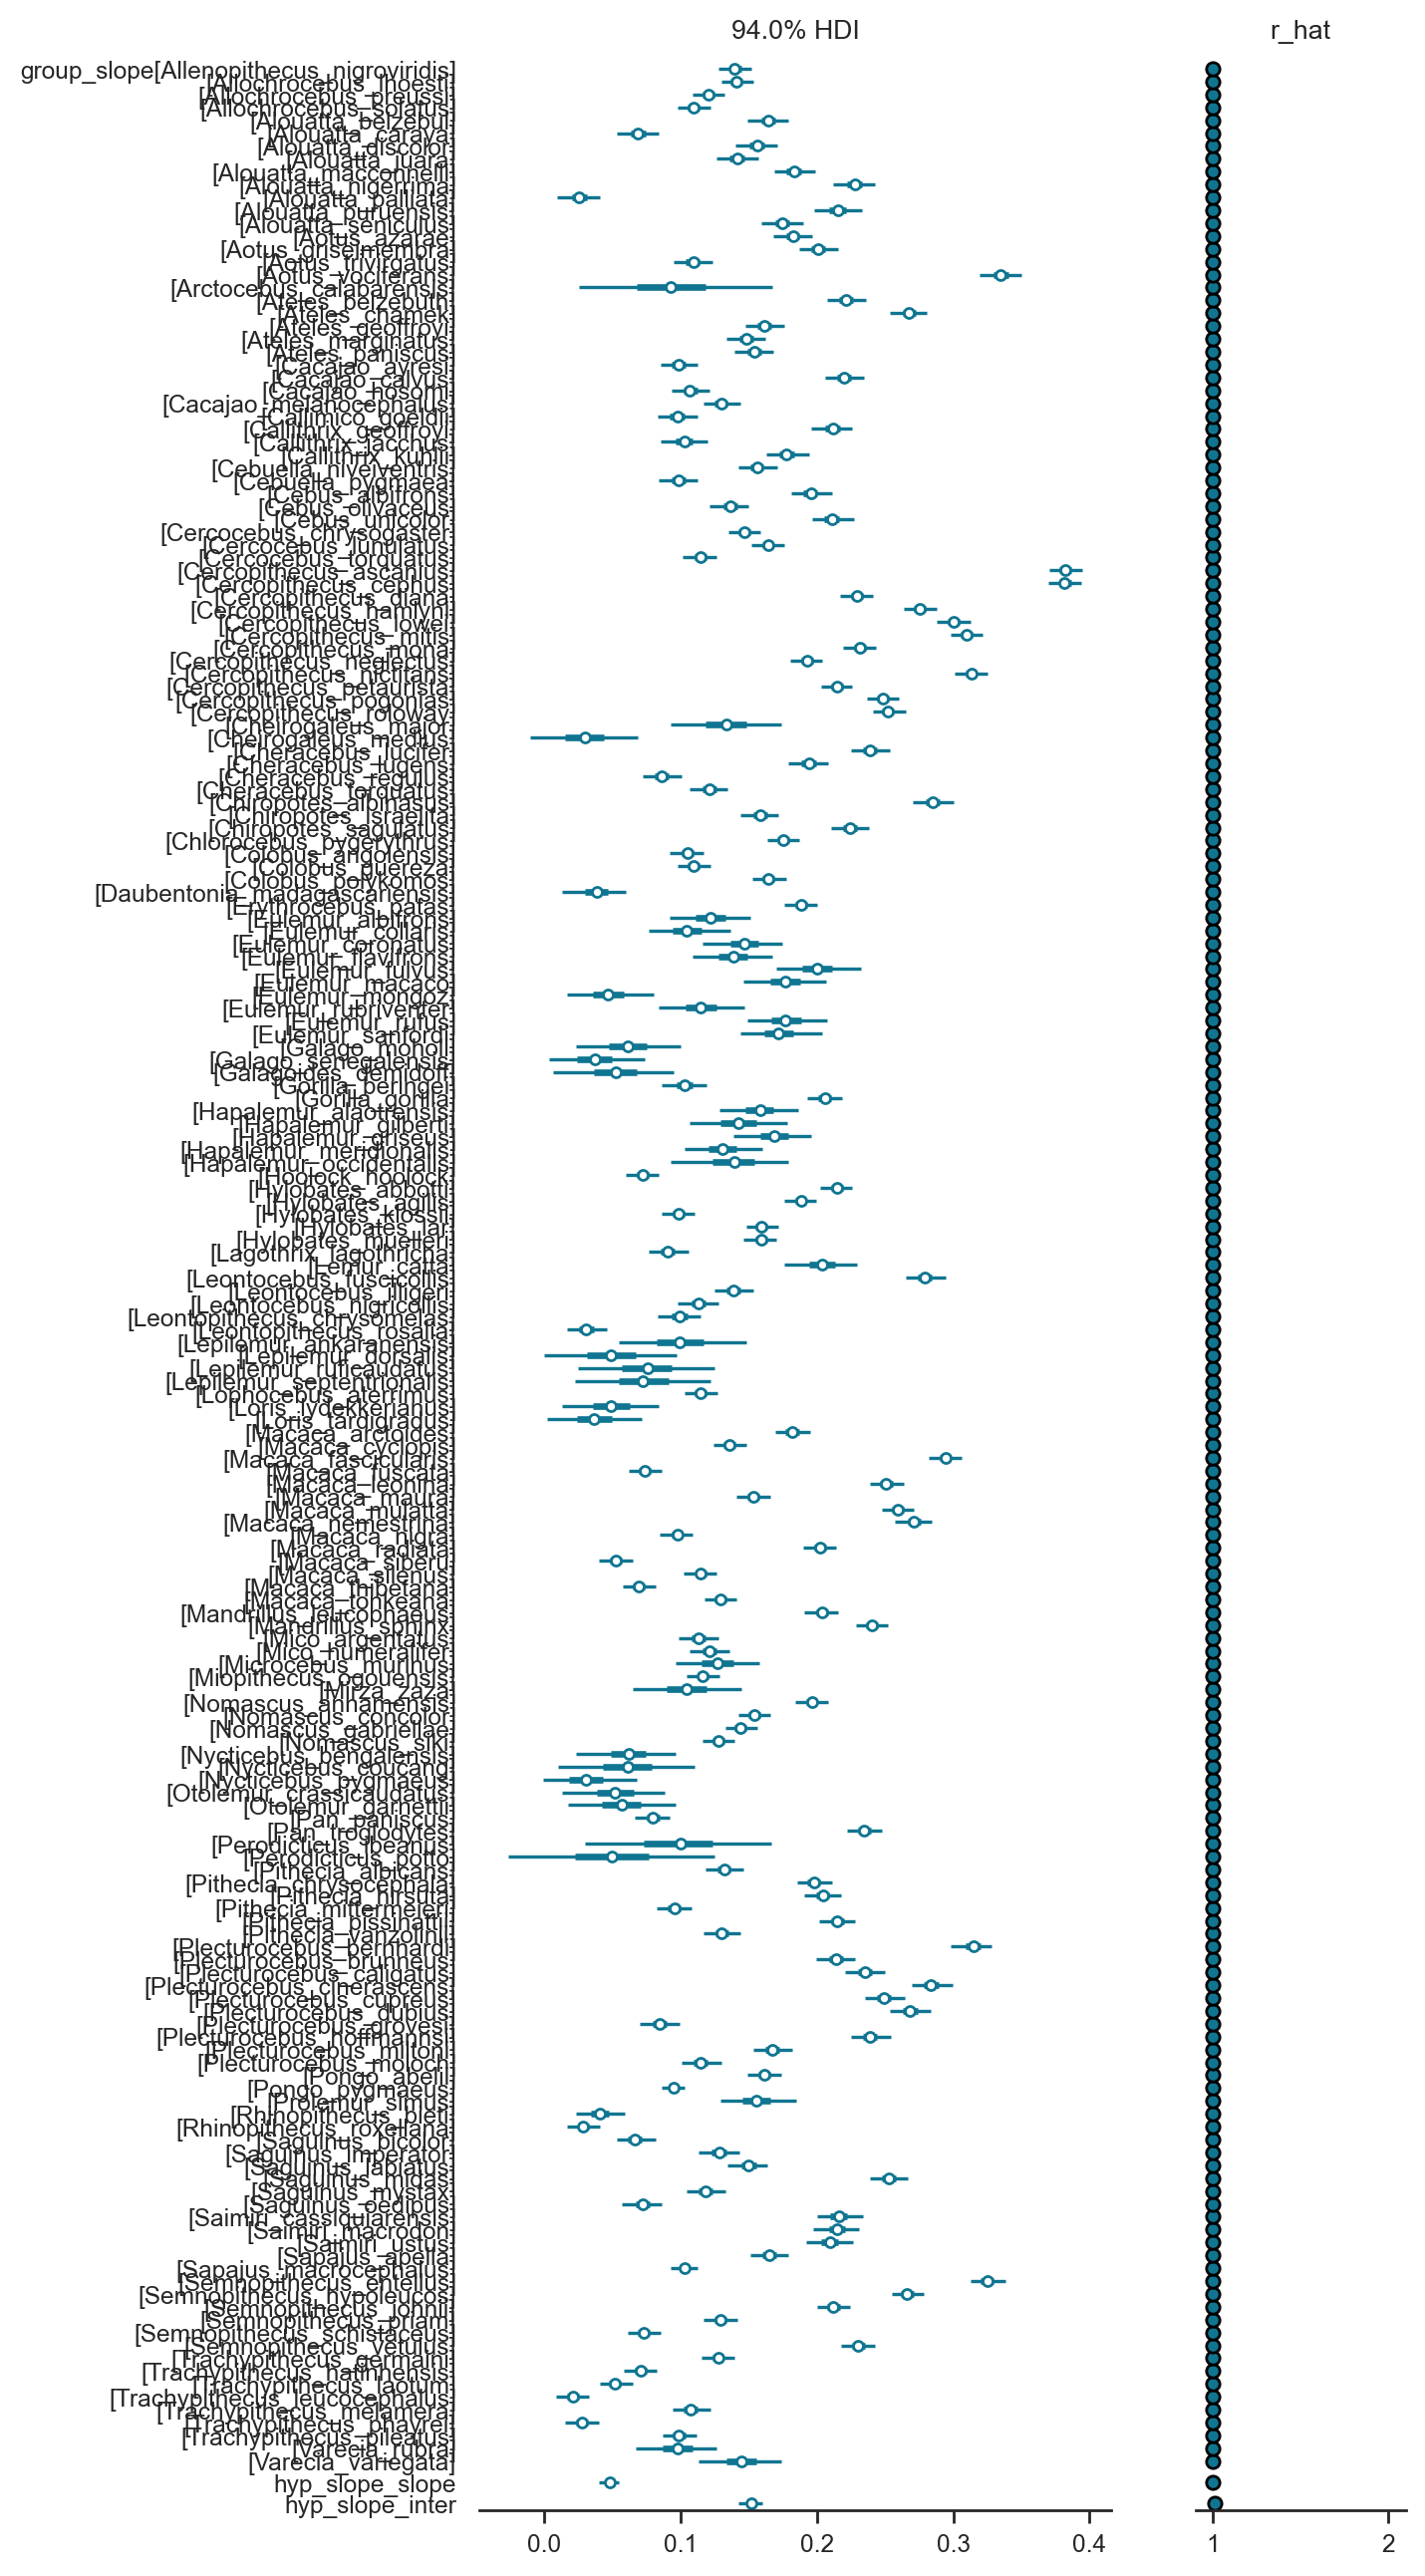

In [33]:
ax = pm.plot_forest(
    idata_hierarchical,
    var_names=["group_slope", "hyp_slope_slope", "hyp_slope_inter"],
    figsize=(6, 16),
    combined=True,
    r_hat=True,
    # backend_kwargs={'font' : {'family' : 'normal',
    #     'weight' : 'bold',
    #     'size'   : 22}},
    # labeller=az.labels.NoVarLabeller(),
)
#ax[0].set_yticks(fontsize=20)
#ax[0].set_ylabel("alpha")

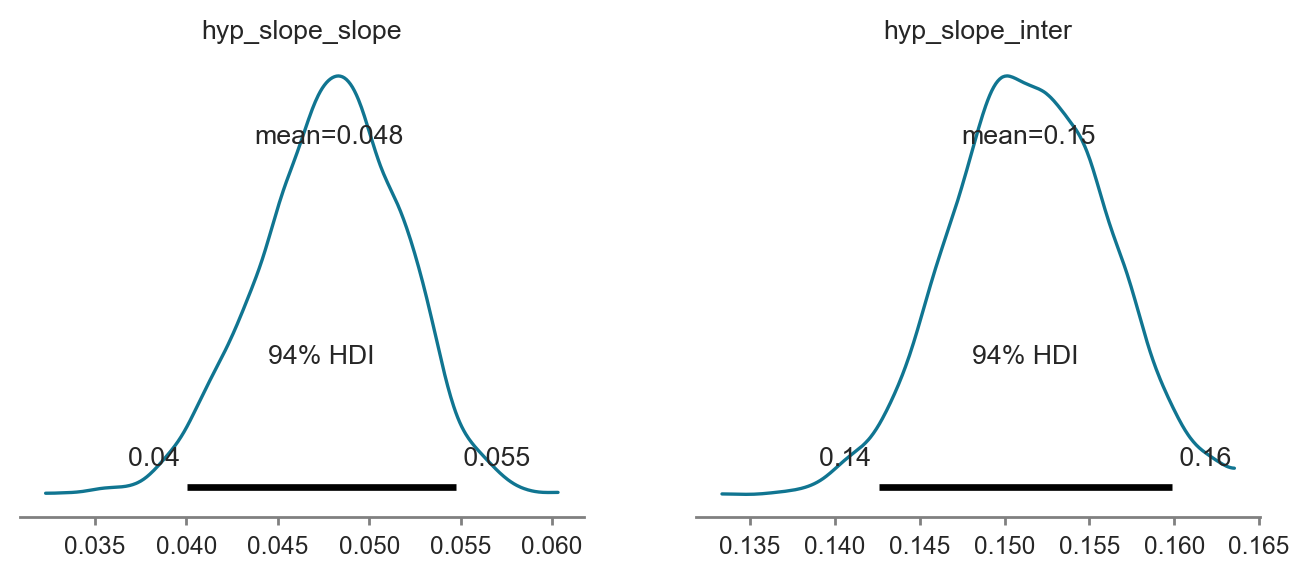

In [34]:
pm.plot_posterior(idata_hierarchical, var_names=["hyp_slope_slope", "hyp_slope_inter"], figsize=(8, 3));

In [35]:
selected_groups

['Gorilla_gorilla', 'Chiropotes_albinasus', 'Saimiri_ustus']

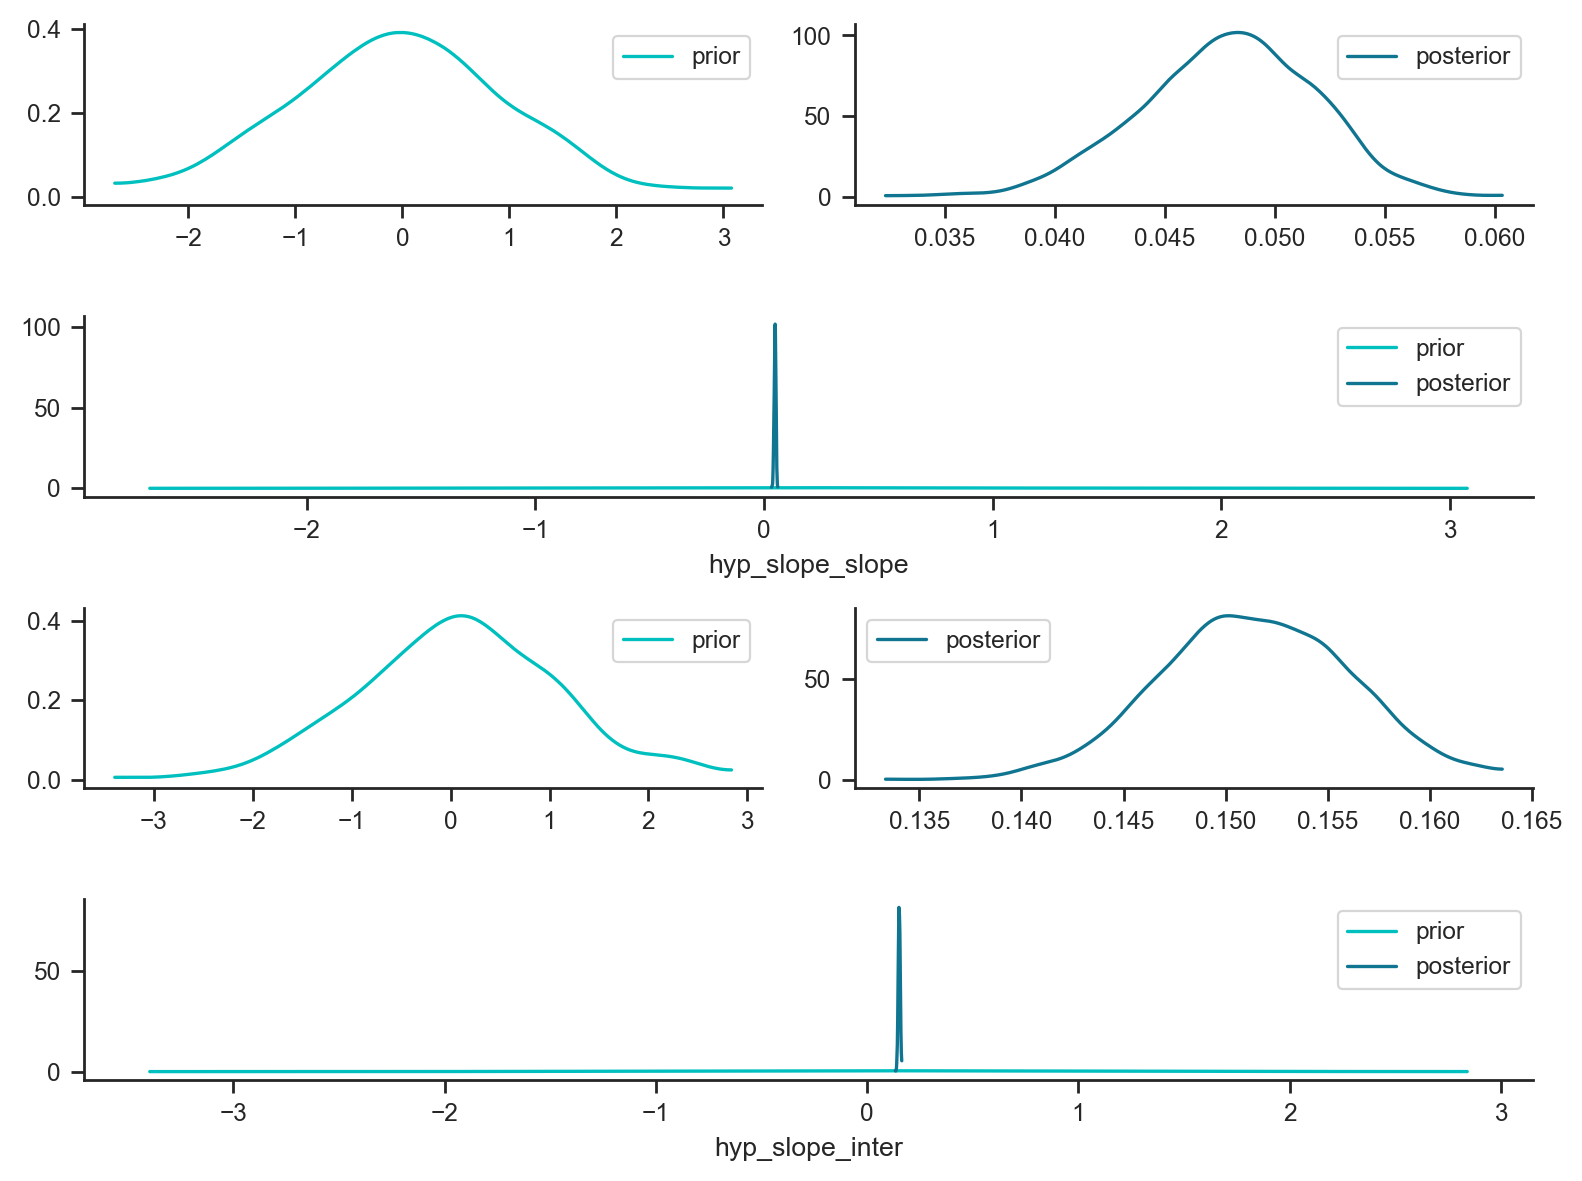

In [36]:
az.plot_dist_comparison(idata_hierarchical, var_names=["hyp_slope_slope", "hyp_slope_inter"], 
                        coords={"global_group" : selected_groups},
                        figsize=(8, 6))
plt.tight_layout()

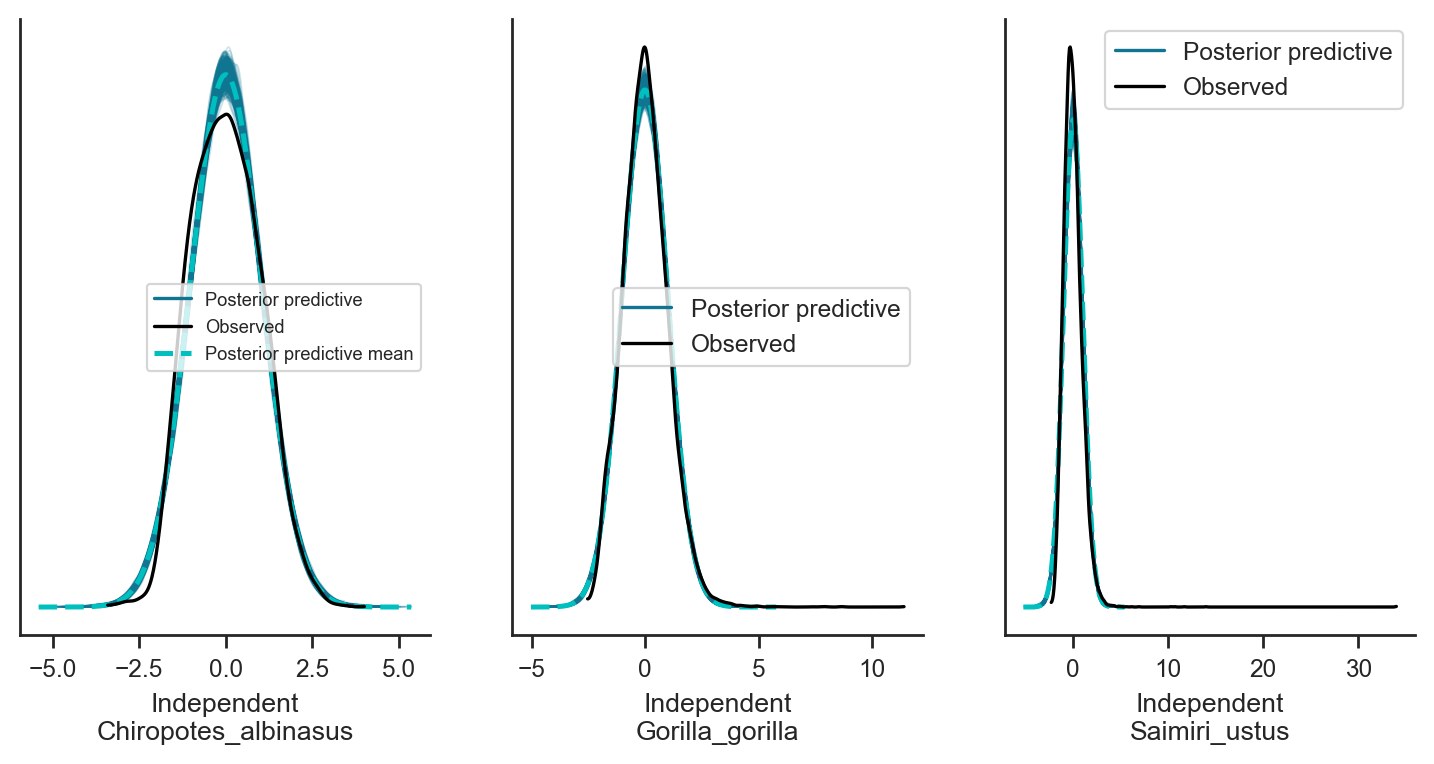

In [37]:
obs_group = idata_hierarchical.posterior["global_group"][idata_hierarchical.constant_data["global_group_member"]]
_idata = idata_hierarchical.assign_coords(obs_id=obs_group, groups="observed_vars")
#_idata = idata.assign_coords(obs_id=obs_group)
az.plot_ppc(_idata, group='posterior', 
            coords={'obs_id': selected_groups}, 
            flatten=[], figsize=(9, 4)) ;

In [38]:
# az.plot_ppc(_idata, group='posterior', flatten=[], figsize=(15, 10))
# plt.gca().legend(bbox_to_anchor=(1.1, 1.05))
# plt.tight_layout()

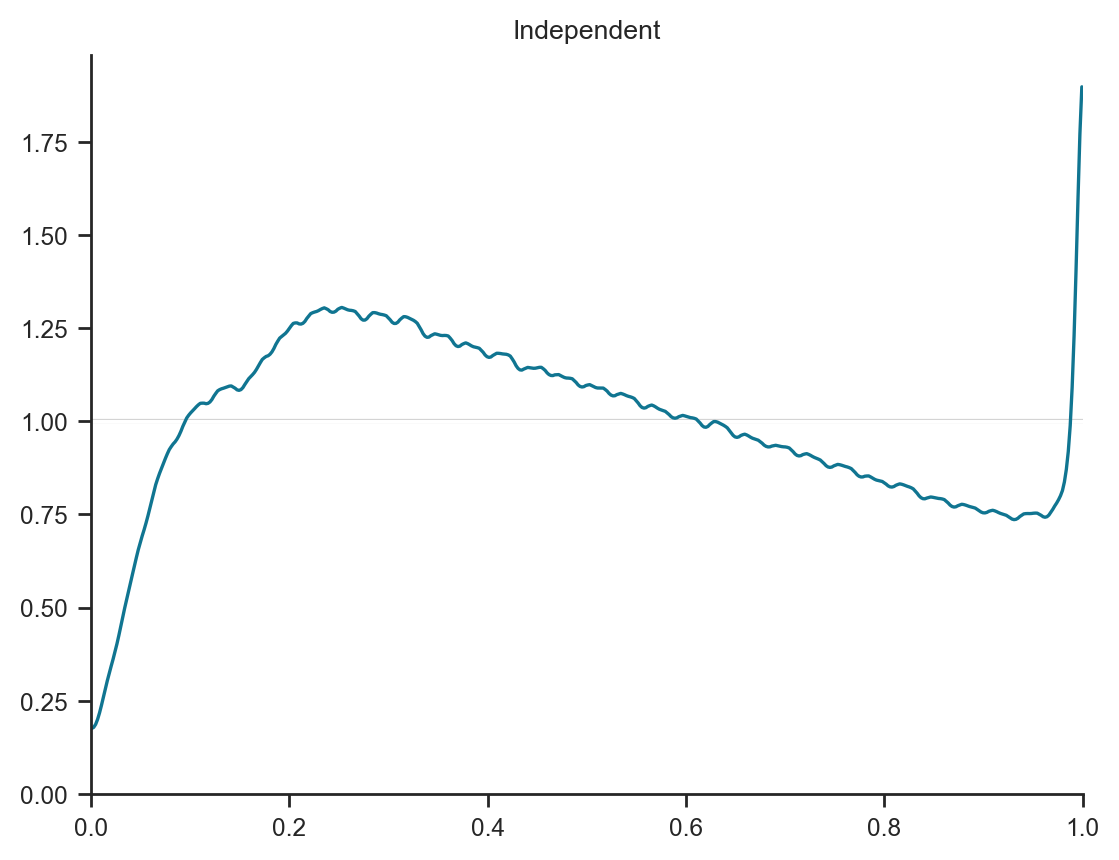

In [39]:
az.plot_bpv(idata_hierarchical) ;

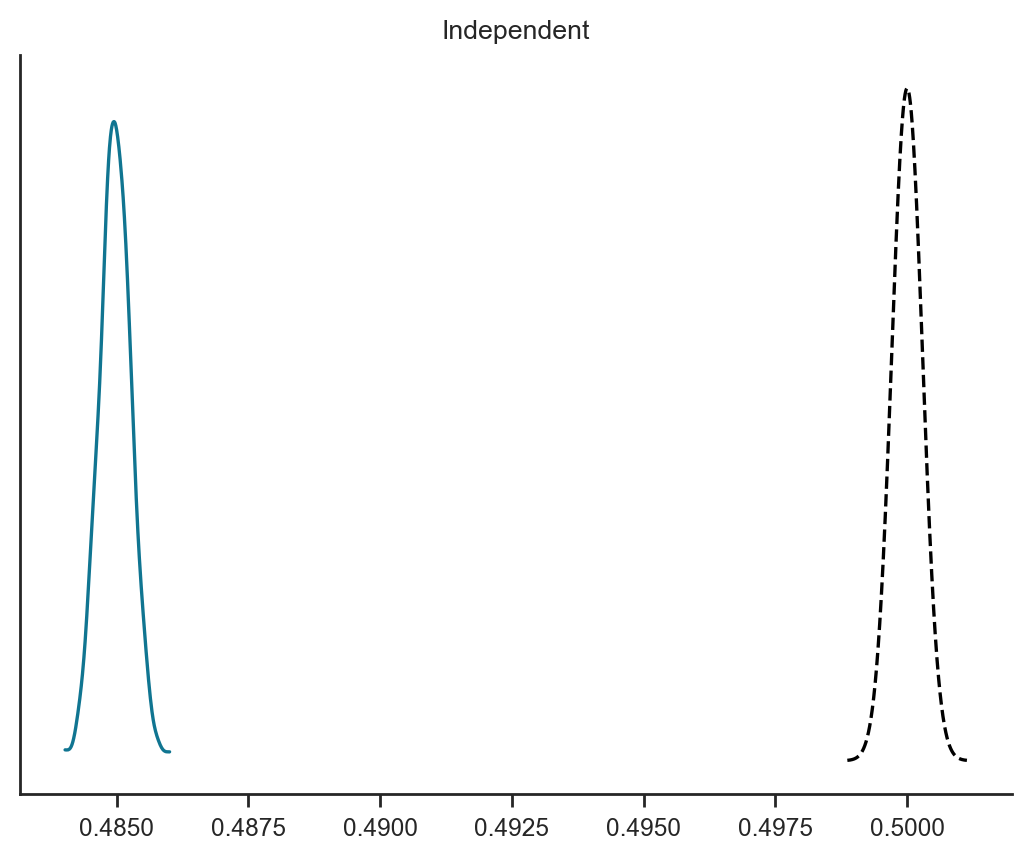

In [40]:
az.plot_bpv(idata_hierarchical, kind="p_value") ;

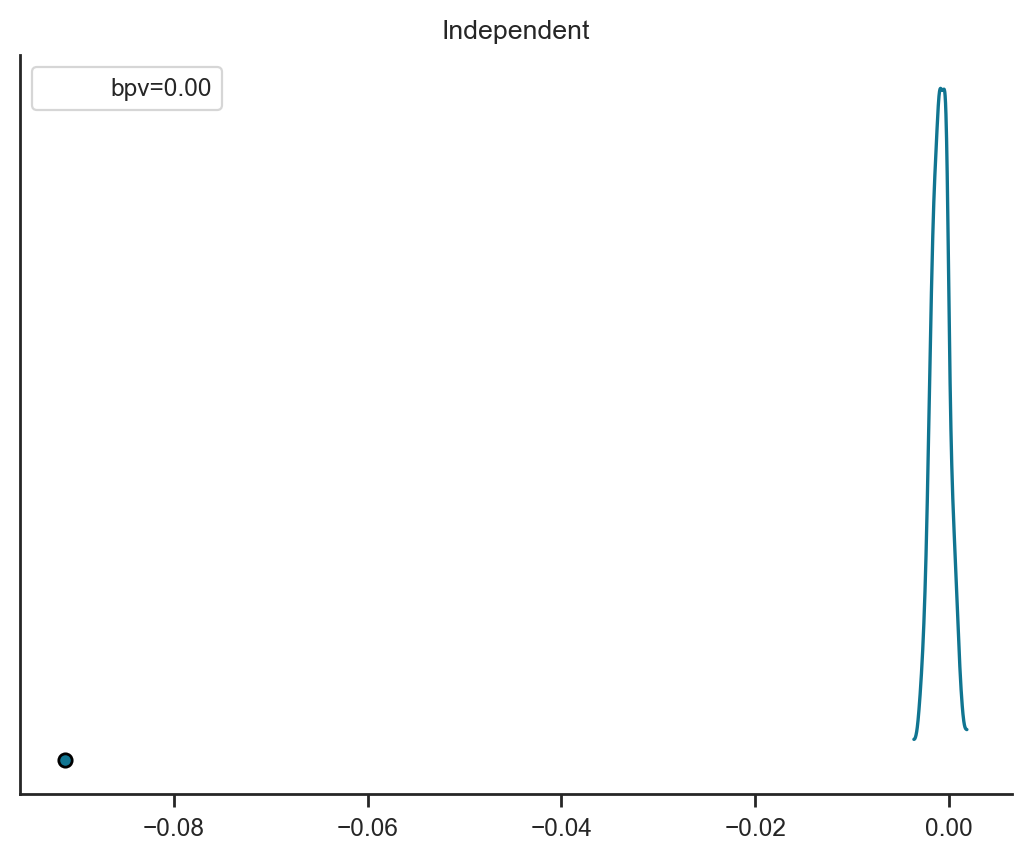

In [41]:
az.plot_bpv(idata_hierarchical, kind="t_stat", t_stat=lambda x:np.percentile(x, q=50, axis=-1)) ;

In [42]:
for p in ['hyp_inter_inter', 'hyp_inter_slope', 'hyp_slope_inter', 'hyp_slope_slope', 'group_inter_residual',
          'group_slope_residual', 'sigma_inter', 'sigma_slope', 'sigma_window_independent']:
    idata_hierarchical.posterior[p].to_dataframe().to_hdf(f"{p}.h5", key='df')

# Model performance

## Loo ELPD

In [43]:
# thin a sampled inferencedata by keeping 1 out of every 5 draws before passing it to compute_log_likelihood
thinned_idata = idata_hierarchical.sel(draw=slice(None, None, 5))
with model_hierarchical:
    idata_hierarchical.extend(pm.compute_log_likelihood(thinned_idata))

In [ ]:
loo_hierarchical = az.loo(idata_hierarchical)
loo_hierarchical

In [ ]:
loo_pointwise_hierarchical = az.loo(idata_hierarchical, pointwise=True)
loo_hierarchical

Save as pandas series:

In [65]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) # I know ...
    
    loo_hierarchical.to_hdf('loo_hierarchical.h5', key='df')
    loo_pointwise_hierarchical.to_hdf('loo_pointwise_hierarchical.h5', key='df')    

Turn back into arviz `ELPDData`:

In [67]:
from arviz.stats import ELPDData
loo_hierarchical = ELPDData(pd.read_hdf('loo_hierarchical.h5'))
loo_hierarchical

Computed from 800 posterior samples and 2940166 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4122802.30  5102.07
p_loo      286.87        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                           Count   Pct.
(-Inf, 0.5]   (good)     2938948  100.0%
 (0.5, 0.7]   (ok)          1202    0.0%
   (0.7, 1]   (bad)           16    0.0%
   (1, Inf)   (very bad)       0    0.0%

## Khat

<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

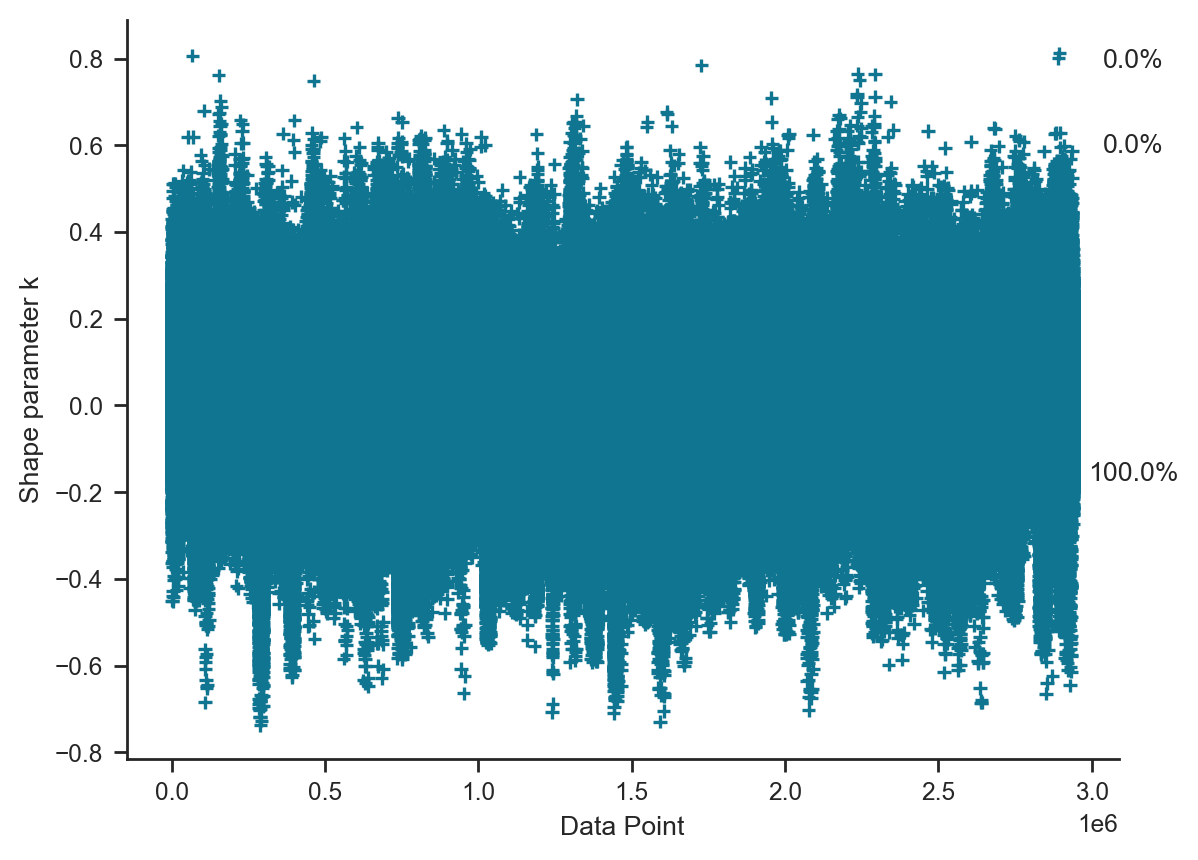

In [68]:
az.plot_khat(loo_hierarchical, show_bins=True) ;

In [ ]:
az.plot_khat(loo_pointwise_hierarchical.pareto_k, xlabels=True, threshold=1)

In [ ]:
counties = radon.posterior.County[radon.constant_data.county_idx].values
colors = [
    "blue" if county[-1] in ("A", "N") else "green" for county in counties
]
az.plot_khat(loo_radon, color=colors)

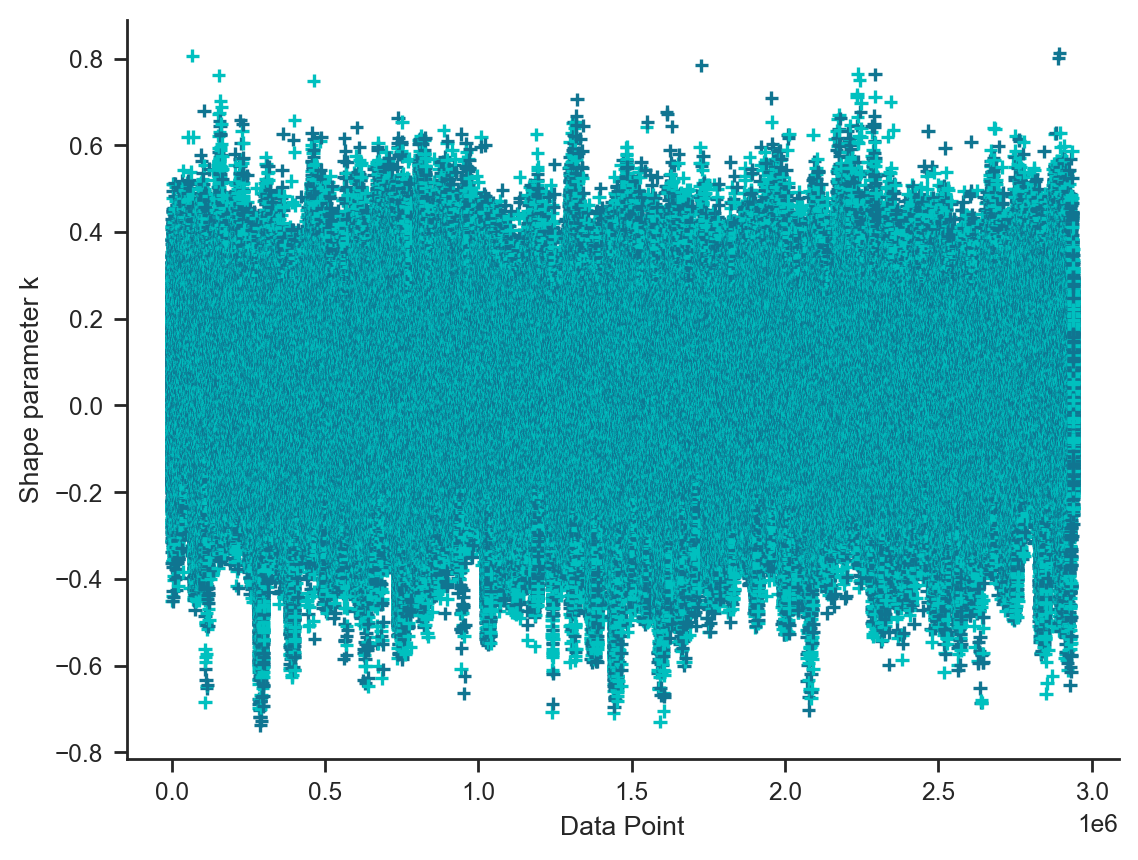

In [72]:
groups = idata_hierarchical.posterior.global_group[idata_hierarchical.constant_data.global_group_member].values
colors = [
    "C0" if i % 2 else "C1" for (i, gr) in enumerate(groups)
]
az.plot_khat(loo_hierarchical, color=colors) ;

## WAIC

In [73]:
waic_hierarchical = az.waic(idata_hierarchical)
waic_hierarchical

In [74]:
waic_pointwise_hierarchical = az.waic(idata_hierarchical, pointwise=True)
waic_pointwise_hierarchical

In [75]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) # I know ...
    
    waic_hierarchical.to_hdf('waic_hierarchical.h5', key='df')
    waic_pointwise_hierarchical.to_hdf('waic_pointwise_hierarchical.h5', key='df')   

Turn back into arviz `ELPDData`:

In [76]:
from arviz.stats import ELPDData
waic_hierarchical = ELPDData(pd.read_hdf('waic_hierarchical.h5'))
waic_pointwise_hierarchical = ELPDData(pd.read_hdf('waic_pointwise_hierarchical.h5'))

In [77]:
waic_hierarchical

Computed from 800 posterior samples and 2940166 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4122801.36  5102.07
p_waic      285.92        -

There has been a warning during the calculation. Please check the results.

In [78]:
waic_pointwise_hierarchical

Computed from 800 posterior samples and 2940166 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4122801.36  5102.07
p_waic      285.92        -

There has been a warning during the calculation. Please check the results.